# Beta

**2.4. Procedure**

This study includes ***four*** blocks of online BCI experiments with a cued-spelling task. The experiments were as follows. Each block consisted of ***40 trials***, and there was one trial for each stimulus target in a randomized order. Trials began with a 0.5 s cue (a red square covering the target) for gaze shift, which was followed by flickering on all the targets, and ended with a rest time of 0.5 s.

In [56]:
# imports

import mne
import numpy as np
import matplotlib.pyplot as plt
import warnings

from copy import deepcopy
from scipy.io import loadmat
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, RFE, RFECV, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Load

In [57]:
# pré-carregamento
data = loadmat(f"../datasets/beta/S9.mat")['data'][0][0]

# 40 targets (40 frequencias pra olhar)
# 64 eletrodos 
# 750 pontos
# 4 trials (4 tentativas do protocolo)
# -> 4, 64, 40, 750
# -> diminuir os 64 para apenas os eletrodos uteis (ocipital)
eeg_data = data[0]
print(eeg_data.shape)

# data structure
print('\nInformações dos dados:')
for field in ['sub', 'age', 'gender', 'chan', 'freqs', 'phases', 'bci_quotient', 'wide_snr', 'narrow_snr','srate']:
  if field != 'chan':
    print(f'=> {field} {data[1][field][0][0].flatten().shape} : {data[1][field][0][0].flatten()}')
  else:
    channels = [data[1][field][0][0][index][3][0] for index in range(64)]
    print(f'=> {field} {len(channels)} : {channels}')
    #selected_ch = [idx for idx, c in enumerate(channels) if c in ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']]
    #print(selected_ch)

(64, 750, 4, 40)

Informações dos dados:
=> sub (1,) : ['S9']
=> age (1,) : [21.33333333]
=> gender (1,) : ['female']
=> chan 64 : ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']
=> freqs (40,) : [ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4]
=> phases (40,) : [4.71238898 0.         1.57079633 3.14159265 4.71238898 0.
 1.57079633 3.14159265 4.71238898 0.         1.57079633 3.14159265
 4.71238898 0.         1.57079633 3.14159265 4.71238898 0.
 1.57079633 3.14159265 4.7123

#### Load Data

In [58]:
# extração direta dos dados
print("Divisão dos dados:")
# opções: ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2'] -> [47, 53, 54, 55, 56, 57, 60, 61, 62]
# eeg = eeg[[], :, :, :] # (64, 750, 4, 40) -> (x, 750, 4, 40)

eeg = eeg_data.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2] * eeg_data.shape[3])
labels = np.array(list(data[1]['freqs'][0][0].flatten()) * 4)
print(eeg.shape, labels.shape)

Divisão dos dados:
(64, 750, 160) (160,)


#### Create MNE

In [59]:
# criação de um objeto "info"
n_channels = 64
sfreq = data[1]['srate'][0][0][0][0]
ch_names = [data[1]['chan'][0][0][index][3][0] for index in range(64)]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

In [60]:
# data : array, shape (n_epochs, n_channels, n_times)
# (64, 750, 160) -> (160, 64, 750)
data_correct = eeg.swapaxes(0, 2)
data_correct = data_correct.swapaxes(1, 2)
print(data_correct.shape)

# adicionando label como "épocas" do sinal
# labels = np.load("../datasets/avi/single/labels.npy")[0]
# # print(labels, labels.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(len(labels), dtype=int),
    le.fit_transform(labels))
)
# print(events)

event_dict = {'8.6': 3, '8.8': 4, '9.0': 5, '9.2': 6, '9.4': 7, '9.6': 8, '9.8': 9, '10.0': 10, '10.2': 11, '10.4': 12, '10.6': 13, '10.8': 14, '11.0': 15, '11.2': 16, '11.4': 17, '11.6': 18, '11.8': 19, '12.0': 20, '12.2': 21, '12.4': 22, '12.6': 23, '12.8': 24, '13.0': 25, '13.2': 26, '13.4': 27, '13.6': 28, '13.8': 29, '14.0': 30, '14.2': 31, '14.4': 32, '14.6': 33, '14.8': 34, '15.0': 35, '15.2': 36, '15.4': 37, '15.6': 38, '15.8': 39, '8.0': 0, '8.2': 1, '8.4': 2}

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
# print(mne_data)

(160, 64, 750)
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated


#### Visualização

PSD do evento com label 9.8


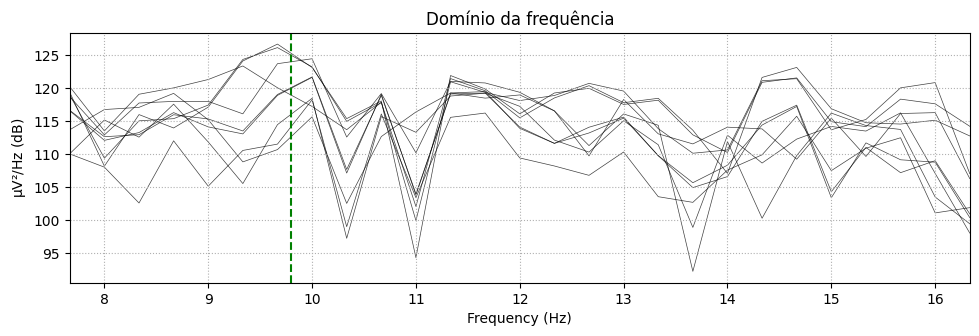

PSD do evento com label 10.6


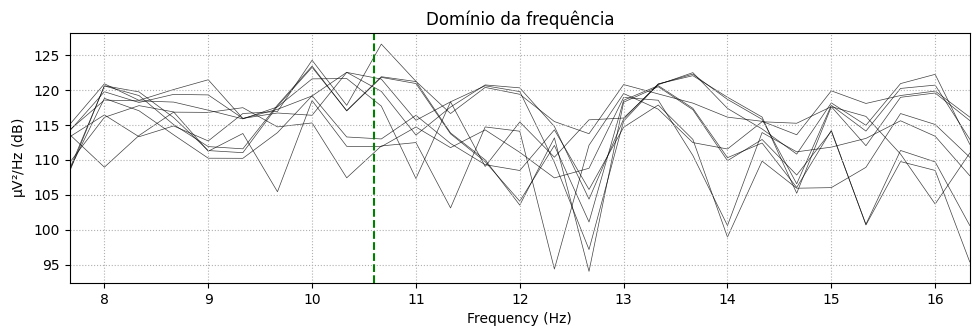

PSD do evento com label 12.600000000000001


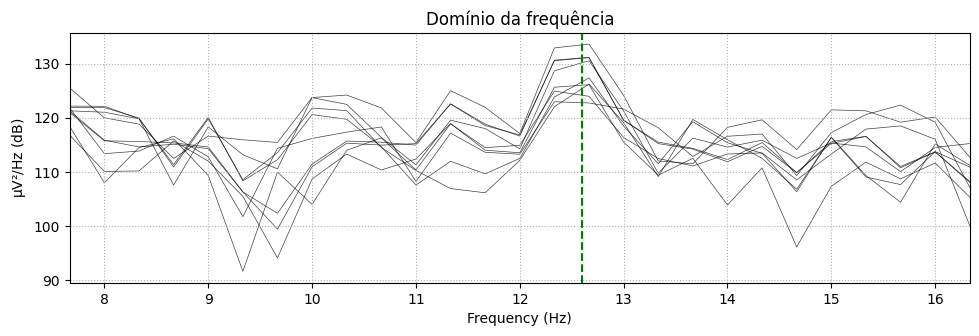

PSD do evento com label 15.600000000000001


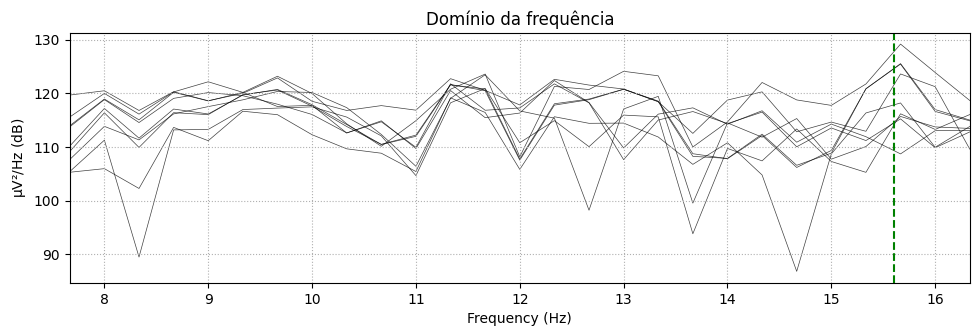

PSD do evento com label 12.600000000000001


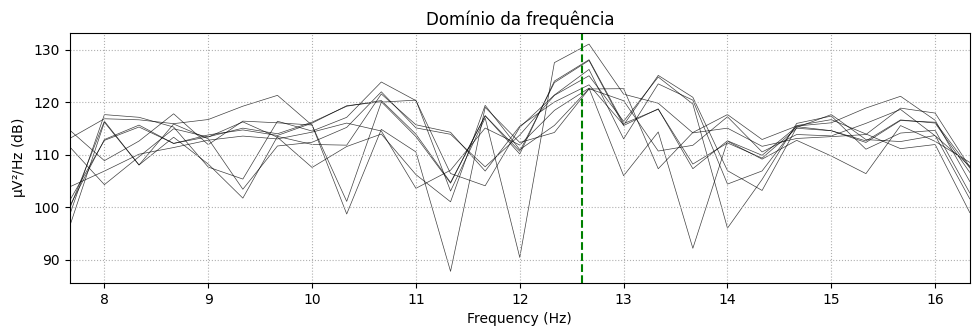

In [61]:
# import warnings
# warnings.filterwarnings('ignore')

mne_data_drop = mne_data.copy()
mne_data_drop = mne_data_drop.drop_channels([name for name in ch_names if name not in ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']]) # ['O1', 'OZ', 'O2']]) #

for i in [6, 10, 20, 35, 100]: #range(len(mne_data)):
    print('PSD do evento com label', labels[i])
    view = mne_data_drop[i].compute_psd(method='welch', fmin=7.5, fmax=16.5, verbose=False)
    view.plot(show=False)
    # print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data_drop[i].event_id)[0]), linestyle='--', color='green')
    plt.show()
# list(mne_data[0].event_id)

#### Classificador por Frequência Mais Alta

In [62]:
threshold = 0.5
freqs = data[1]['freqs'][0][0].flatten()

y_pred = []

#para todas as instancias
for i in range(len(mne_data_drop)):
    #psd
    item = mne_data_drop[i].compute_psd(method='welch', fmin=7.5, fmax=16.5, verbose=False)
    
    #pegar media de cada faixa de frequencia
    classes = []
    for freq in freqs:        
        classes.append( item.get_data(fmin=freq-threshold, fmax=freq+threshold).mean() )
    
    #verificar qual é a maior faixa de freq
    y_pred.append( freqs[np.argmax(classes)] )
    
#calcular acuracia
acuracia = 100 * sum(y_pred == labels) / len(labels)
print(f'Acurácia: {acuracia:.2f}%')

Acurácia: 24.38%


#### Classificador por SVM


*Estimando o ruído de fundo*

In [63]:
dataset = deepcopy(data_correct)
print(dataset.shape)

# intervalos de tempo sem estímulo (0 a 0,5 segundos e 2,5 a 3 segundos)
base_start = 0
base_end = 125
rest_start = 625
rest_end = 750

# Estimando o ruído de fundo
estimated_background_noise = []

for trial in dataset: #para cada sinal   
    noise_power = [] # armazena uma lista com as médias de potência para cada canal

    for electrode in trial:
        psd = np.abs(np.fft.fft(electrode)) ** 2

        # média da potência nos intervalos de tempo sem estímulo
        base_power = np.mean(psd[base_start:base_end])
        rest_power = np.mean(psd[rest_start:rest_end])
        mean_noise_power = (base_power + rest_power) / 2

        noise_power.append(mean_noise_power)

    #média das médias de potência de todos os canais para estimar o ruído de fundo
    estimated_background_noise.append(np.mean(noise_power))
# end


background_noise = np.array(estimated_background_noise)
print(background_noise.shape)
# print(background_noise)

(160, 64, 750)
(160,)


*Amplitudes*

In [64]:
freq = sfreq

# frequências alvo
target_frequencies = np.arange(8, 16, 0.2)
target_amplitudes = []

for trial in dataset: #para cada sinal   
    # lista para armazenar as amplitudes nas frequências alvo
    amp = []

    for electrode in trial:
        fft_result = np.fft.fft(electrode)
        psd = np.abs(fft_result) ** 2
        frequencies = np.fft.fftfreq(len(fft_result), 1 / freq)

        amp_trial = []
        for target_frequency in target_frequencies:
            # encontrando o índice da frequência alvo no espectro de frequência
            index = np.argmin(np.abs(frequencies - target_frequency))
            # amplitude na frequência alvo
            amplitude = np.sqrt(psd[index])
            amp_trial.append(amplitude)

        amp.append(amp_trial)
    
    target_amplitudes.append(amp)

target_amplitudes = np.array(target_amplitudes)
print(target_amplitudes.shape)

(160, 64, 40)


*SNR*

In [65]:
def narrow_band_SNR(target_amplitudes, estimated_background_noise):
  target_amplitudes_adjusted = np.abs(target_amplitudes - estimated_background_noise) # subtraindo o ruído de fundo das amplitudes
  return 10 * np.log10(target_amplitudes_adjusted / estimated_background_noise)

def wide_band_SNR(target_amplitudes, estimated_background_noise):
  target_amplitudes_adjusted = np.abs(target_amplitudes - estimated_background_noise)
  total_power = np.sum(target_amplitudes_adjusted)
  return 10 * np.log10(target_amplitudes_adjusted / total_power)

def adjusted_amplitudes(target_amplitudes, estimated_background_noise):
  return np.abs(target_amplitudes - estimated_background_noise)

def mean_freqs(data, threshold, method):
  psd = data.compute_psd(method=method, fmin=7.5, fmax=16.5, verbose=False)
  data = np.array([psd.get_data(fmin=f-threshold, fmax=f+threshold).mean(axis=-1) for f in freqs])
  return data.reshape(data.shape[0] * data.shape[1], data.shape[2]).swapaxes(0,1)

*Vetor de Características*

In [66]:
dataset = mne_data.copy()
X = []
y = labels

# for i, trial in enumerate(dataset):
for i in range(len(dataset)):
  X.append([
    narrow_band_SNR(target_amplitudes[i], background_noise[i]),
    wide_band_SNR(target_amplitudes[i], background_noise[i]),
    adjusted_amplitudes(target_amplitudes[i], background_noise[i]),
    mean_freqs(dataset[i], 0.2, 'welch')
  ])
  
X = np.array(X)
X = X.swapaxes(1, 2)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2]*X.shape[3])
print(X.shape)

(160, 64, 160)


*Remoção Manual de Características*

In [67]:
warnings.filterwarnings('ignore')

# Remoção
# opções: ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2'] -> [47, 53, 54, 55, 56, 57, 60, 61, 62]
Xmanual = deepcopy(X)
Xmanual = Xmanual[:,[47, 53, 54, 55, 56, 57, 60, 61, 62],:]
Xmanual = Xmanual.reshape(Xmanual.shape[0], Xmanual.shape[1]*Xmanual.shape[2])

#preparing
Xmanual = StandardScaler().fit_transform(Xmanual)
ym = LabelEncoder().fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(Xmanual, ym, test_size=0.25, random_state=42)

#svm
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf', 'poly']},
]
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, cv=2)
grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)

print(f'Acurácia: {100 * accuracy_score(y_test, y_pred):.2f}%')

Acurácia: 27.50%


*Remoção Automática de Características*

In [68]:
warnings.filterwarnings('ignore')

# preparing
Xauto = deepcopy(X)
Xauto = Xauto.reshape(Xauto.shape[0], Xauto.shape[1]*Xauto.shape[2])
Xauto = StandardScaler().fit_transform(Xauto)
ya = LabelEncoder().fit_transform(y)
print(Xauto.shape, ya.shape)

# KBest
kb = SelectKBest(f_classif, k=130)
X_final = kb.fit_transform(Xauto, ya)

#rfe
# rfe = RFECV(svm.SVC(kernel="linear"), step=0.0001, min_features_to_select=130, cv=2)
# # rfe = RFE(svm.SVC(kernel="linear"), step=0.0001, n_features_to_select=0.05)
# X_final = rfe.fit_transform(Xauto, ya)

# X_final = StandardScaler().fit_transform(X_final)
print(X_final.shape)

# treino/teste
x_train, x_test, y_train, y_test = train_test_split(X_final, ya, test_size=0.25, random_state=42)

#svm
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']}]
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, cv=2)
grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)

print(f'Acurácia: {100 * accuracy_score(y_test, y_pred):.2f}%')


(160, 10240) (160,)
(160, 130)
Acurácia: 72.50%
